# Cleaning & Merge

In [7]:
import pandas as pd

# Load the data
mgp_prices = pd.read_csv('../data/mgp_prices.csv', parse_dates=['Unnamed: 0']).rename(columns={'Unnamed: 0': 'datetime'})
ntc = pd.read_csv('../data/day_ahead_ntc.csv', parse_dates=['Unnamed: 0']).rename(columns={'Unnamed: 0': 'datetime'})
gas_price = pd.read_csv('../data/ttf_gas_price.csv', parse_dates=['Date']).rename(columns={'Date': 'datetime'})
wind_solar = pd.read_csv('../data/wind_solar_generation.csv', parse_dates=['Unnamed: 0']).rename(columns={'Unnamed: 0': 'datetime'})
load_forecast = pd.read_csv('../data/day_ahead_load_forecast.csv', parse_dates=['Unnamed: 0']).rename(columns={'Unnamed: 0': 'datetime'})

In [8]:
load_forecast.head()

,datetime,IT_NORD,IT_CNOR,IT_SARD,IT_CSUD,IT_SUD,IT_CALA,IT_SICI,IT
0,2023-01-01 00:00:00+01:00,10082.0,1754.0,820.0,4221.0,1593.0,620.0,1672.0,20762.0
1,2023-01-01 01:00:00+01:00,9383.0,1632.0,790.0,3915.0,1296.0,572.0,1632.0,19220.0
2,2023-01-01 02:00:00+01:00,8877.0,1577.0,757.0,3804.0,1183.0,555.0,1527.0,18280.0
3,2023-01-01 03:00:00+01:00,8580.0,1554.0,730.0,3587.0,1127.0,510.0,1465.0,17553.0
4,2023-01-01 04:00:00+01:00,8893.0,1528.0,717.0,3401.0,1324.0,412.0,1395.0,17670.0


In [9]:
gas_price.head()

,datetime,Price
0,2024-10-01,38.515
1,2024-09-01,39.044
2,2024-08-01,39.825
3,2024-07-01,35.870
4,2024-06-01,34.480


In [10]:
# Define main zones with corresponding inflow and outflow columns based on the provided list
main_zones_ntc = {
    'IT_NORD': (['CH > IT_NORD', 'FR > IT_NORD', 'SI > IT_NORD', 'AT > IT_NORD', 'IT_CNOR > IT_NORD'],
                ['IT_NORD > CH', 'IT_NORD > FR', 'IT_NORD > SI', 'IT_NORD > AT', 'IT_NORD > IT_CNOR']),
    'IT_CNOR': (['IT_CSUD > IT_CNOR'],
                ['IT_CNOR > IT_NORD', 'IT_CNOR > IT_CSUD']),
    'IT_CSUD': (['IT_SUD > IT_CSUD', 'IT_CNOR > IT_CSUD'],
                ['IT_CSUD > IT_SUD', 'IT_CSUD > IT_CNOR', 'IT_CSUD > IT_SARD']),
    'IT_SUD': (['GR > IT_SUD', 'IT_CSUD > IT_SUD', 'IT_CALA > IT_SUD'],
               ['IT_SUD > GR', 'IT_SUD > IT_CSUD', 'IT_SUD > IT_CALA']),
    'IT_CALA': (['IT_SUD > IT_CALA'],
                ['IT_CALA > IT_SUD', 'IT_CALA > IT_SICI']),
    'IT_SICI': (['IT_CALA > IT_SICI'],
                ['IT_SICI > IT_CALA']),
    'IT_SARD': (['IT_CSUD > IT_SARD'],
                ['IT_SARD > IT_CSUD']),
    # IT inflow and outflow from external connections (e.g., AT > IT)
    'IT': (['AT > IT', 'FR > IT', 'GR > IT', 'ME > IT', 'SI > IT', 'CH > IT'],
           ['IT > AT', 'IT > FR', 'IT > GR', 'IT > ME', 'IT > SI', 'IT > CH'])
}

# Calculate inflow and outflow for each main zone and Italy based on the specified columns
for zone, (inflow_cols, outflow_cols) in main_zones_ntc.items():
    ntc[f'{zone}_inflow'] = ntc[inflow_cols].sum(axis=1)
    ntc[f'{zone}_outflow'] = ntc[outflow_cols].sum(axis=1)

# Keep only inflow and outflow columns along with the datetime for merging
ntc = ntc[['datetime'] + [f'{zone}_inflow' for zone in main_zones_ntc] + [f'{zone}_outflow' for zone in main_zones_ntc]]


In [11]:
ntc.head()

,datetime,IT_NORD_inflow,IT_CNOR_inflow,IT_CSUD_inflow,IT_SUD_inflow,IT_CALA_inflow,IT_SICI_inflow,IT_SARD_inflow,IT_inflow,IT_NORD_outflow,IT_CNOR_outflow,IT_CSUD_outflow,IT_SUD_outflow,IT_CALA_outflow,IT_SICI_outflow,IT_SARD_outflow,IT_outflow
0,2023-01-01 00:00:00+01:00,9740.0,3892.0,8690.0,6013.0,1601.0,1404.0,720.0,7195.0,7978.0,6741.0,7775.0,7695.0,3754.0,1533.0,870.0,5495.0
1,2023-01-01 01:00:00+01:00,9740.0,3892.0,8690.0,6013.0,1601.0,1404.0,720.0,7195.0,7978.0,6741.0,7775.0,7695.0,3754.0,1533.0,870.0,5495.0
2,2023-01-01 02:00:00+01:00,9740.0,3892.0,8690.0,6013.0,1601.0,1404.0,720.0,7195.0,7978.0,6741.0,7775.0,7695.0,3754.0,1533.0,870.0,5495.0
3,2023-01-01 03:00:00+01:00,9720.0,3892.0,8449.0,6013.0,1568.0,1361.0,720.0,7055.0,7875.0,6620.0,7775.0,7662.0,3711.0,1550.0,870.0,5495.0
4,2023-01-01 04:00:00+01:00,9626.0,3892.0,8449.0,6013.0,1568.0,1361.0,720.0,6961.0,7875.0,6620.0,7775.0,7662.0,3711.0,1550.0,870.0,5495.0


In [12]:
# Step 2: Expand Monthly Gas Prices to Hourly Frequency
gas_price = gas_price.set_index('datetime').resample('H').ffill().reset_index()
gas_price.head()

,datetime,Price
0,2019-01-01 00:00:00,19.85
1,2019-01-01 01:00:00,19.85
2,2019-01-01 02:00:00,19.85
3,2019-01-01 03:00:00,19.85
4,2019-01-01 04:00:00,19.85


In [13]:
# Convert datetime columns to UTC and then remove timezone information
mgp_prices['datetime'] = pd.to_datetime(mgp_prices['datetime'], utc=True).dt.tz_convert(None)
ntc['datetime'] = pd.to_datetime(ntc['datetime'], utc=True).dt.tz_convert(None)
gas_price['datetime'] = pd.to_datetime(gas_price['datetime'], utc=True).dt.tz_convert(None)
wind_solar['datetime'] = pd.to_datetime(wind_solar['datetime'], utc=True).dt.tz_convert(None)
load_forecast['datetime'] = pd.to_datetime(load_forecast['datetime'], utc=True).dt.tz_convert(None)

# Step 3: Merge All Data on the 'datetime' Column
# Start by merging mgp_prices with ntc data
merged_data = pd.merge(mgp_prices, ntc, on='datetime', how='left')

# Merge with gas price data
merged_data = pd.merge(merged_data, gas_price, on='datetime', how='left')

# Merge with wind_solar data
merged_data = pd.merge(merged_data, wind_solar, on='datetime', how='left')

# Merge with load forecast data
merged_data = pd.merge(merged_data, load_forecast, on='datetime', how='left')

# The final merged data will contain all variables aligned to hourly timestamps


In [14]:
merged_data.head()

,datetime,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,...,Wind SICI,Wind SUD,IT_NORD,IT_CNOR,IT_SARD,IT_CSUD,IT_SUD,IT_CALA,IT_SICI,IT
0,2019-01-01 00:00:00,51.00000,51.00,NaN,51.00000,51.00000,51.00000,51.00000,51.00000,51.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,46.27000,46.27,NaN,46.27000,46.27000,46.27000,46.27000,46.27000,46.27000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,39.78000,39.78,NaN,39.78000,39.78000,39.78000,39.78000,39.78000,39.78000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,27.86938,25.00,NaN,27.86938,27.86938,27.86938,27.86938,27.86938,27.86938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,22.00000,22.00,NaN,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Filter the merged_data to keep only rows from January 1, 2023, onward
start_date = "2023-01-01"
merged_data = merged_data[merged_data['datetime'] >= start_date]

# Display the first few rows to confirm
merged_data.head()


,datetime,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,...,Wind SICI,Wind SUD,IT_NORD,IT_CNOR,IT_SARD,IT_CSUD,IT_SUD,IT_CALA,IT_SICI,IT
35064,2023-01-01 00:00:00,195.90,195.90,195.90,195.90,195.90,195.90,195.90,195.90,195.90,...,586.296,1231.026,9383.0,1632.0,790.0,3915.0,1296.0,572.0,1632.0,19220.0
35065,2023-01-01 01:00:00,191.09,191.09,191.09,191.09,191.09,191.09,191.09,191.09,191.09,...,583.534,1236.701,8877.0,1577.0,757.0,3804.0,1183.0,555.0,1527.0,18280.0
35066,2023-01-01 02:00:00,187.95,187.95,187.95,187.95,187.95,187.95,187.95,187.95,187.95,...,575.989,1238.670,8580.0,1554.0,730.0,3587.0,1127.0,510.0,1465.0,17553.0
35067,2023-01-01 03:00:00,187.82,187.82,187.82,187.82,187.82,187.82,187.82,187.82,187.82,...,564.864,1239.051,8893.0,1528.0,717.0,3401.0,1324.0,412.0,1395.0,17670.0
35068,2023-01-01 04:00:00,187.74,187.74,187.74,187.74,187.74,187.74,187.74,187.74,187.74,...,551.844,1237.351,9102.0,1488.0,715.0,3381.0,1339.0,402.0,1377.0,17804.0


In [16]:
# Rename 'Price' to 'Gas_Price' for clarity
merged_data = merged_data.rename(columns={'Price': 'Gas_Price'})

# Rename load forecast columns to avoid confusion
load_forecast_renames = {
    'IT_NORD': 'Load_IT_NORD',
    'IT_CNOR': 'Load_IT_CNOR',
    'IT_SARD': 'Load_IT_SARD',
    'IT_CSUD': 'Load_IT_CSUD',
    'IT_SUD': 'Load_IT_SUD',
    'IT_CALA': 'Load_IT_CALA',
    'IT_SICI': 'Load_IT_SICI',
    'IT': 'Load_IT_Total'
}

# Apply the renaming for load columns
merged_data = merged_data.rename(columns=load_forecast_renames)


In [17]:
# Define the main zones to check for decoupling
main_zones = ['NAT', 'CALA', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD']

# Apply the decoupling condition: any price difference from PUN will be considered as decoupling
merged_data['Decoupling'] = merged_data.apply(
    lambda row: any(row[zone] != row['PUN'] for zone in main_zones),
    axis=1
)

# Convert boolean to integer for easier analysis (1 = decoupling, 0 = no decoupling)
merged_data['Decoupling'] = merged_data['Decoupling'].astype(int)

# Display a sample of the data to verify
merged_data[['datetime', 'PUN'] + main_zones + ['Decoupling']].head()


,datetime,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,Decoupling
35064,2023-01-01 00:00:00,195.90,195.90,195.90,195.90,195.90,195.90,195.90,195.90,195.90,0
35065,2023-01-01 01:00:00,191.09,191.09,191.09,191.09,191.09,191.09,191.09,191.09,191.09,0
35066,2023-01-01 02:00:00,187.95,187.95,187.95,187.95,187.95,187.95,187.95,187.95,187.95,0
35067,2023-01-01 03:00:00,187.82,187.82,187.82,187.82,187.82,187.82,187.82,187.82,187.82,0
35068,2023-01-01 04:00:00,187.74,187.74,187.74,187.74,187.74,187.74,187.74,187.74,187.74,0


In [18]:
# Add a column for the weekday (0 = Monday, 6 = Sunday)
merged_data['Weekday'] = merged_data['datetime'].dt.weekday

# Add a column for the month (1 = January, 12 = December)
merged_data['Month'] = merged_data['datetime'].dt.month

# Display the first few rows to verify
merged_data[['datetime', 'Weekday', 'Month']].head()


,datetime,Weekday,Month
35064,2023-01-01 00:00:00,6,1
35065,2023-01-01 01:00:00,6,1
35066,2023-01-01 02:00:00,6,1
35067,2023-01-01 03:00:00,6,1
35068,2023-01-01 04:00:00,6,1


In [19]:
# Drop the 'ROSN' column if it contains only null values
merged_data = merged_data.drop(columns=['ROSN'])


In [20]:
merged_data.describe()

,datetime,PUN,NAT,CALA,CNOR,CSUD,NORD,SARD,SICI,SUD,...,Load_IT_CNOR,Load_IT_SARD,Load_IT_CSUD,Load_IT_SUD,Load_IT_CALA,Load_IT_SICI,Load_IT_Total,Decoupling,Weekday,Month
count,13705,13705.000000,13705.000000,13705.000000,13705.000000,13705.000000,13705.000000,13705.000000,13705.000000,13705.000000,...,13704.000000,13704.000000,13704.000000,13704.000000,13704.000000,13704.000000,13704.000000,13705.000000,13705.000000,13705.000000
mean,2023-10-13 11:38:15.541773056,115.809764,115.831718,114.287305,116.931138,115.736738,115.883863,112.123514,115.641230,114.574659,...,2721.275102,935.524154,5604.721322,2100.198409,672.797869,1976.665718,31807.071658,0.357388,2.994965,5.582780
min,2023-01-01 00:00:00,0.100000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000,0.000000,0.000000,...,1318.000000,552.000000,3140.000000,693.000000,242.000000,1187.000000,16300.000000,0.000000,0.000000,1.000000
25%,2023-05-23 19:00:00,94.987490,95.060000,94.220000,95.360000,95.000000,95.000000,93.220000,95.000000,94.500000,...,2135.000000,815.000000,4600.000000,1730.000000,535.000000,1660.000000,25744.250000,0.000000,1.000000,3.000000
50%,2023-10-13 13:00:00,110.100000,110.220000,110.000000,110.780000,110.250000,110.080000,110.000000,110.950000,110.000000,...,2616.000000,935.000000,5630.000000,2086.000000,665.000000,1985.000000,31439.000000,0.000000,3.000000,5.000000
75%,2024-03-04 04:00:00,133.740000,133.900000,133.820000,135.000000,134.160000,133.720000,133.910000,135.520000,133.690050,...,3296.250000,1040.000000,6455.000000,2412.000000,775.000000,2220.000000,37580.000000,1.000000,5.000000,8.000000
max,2024-07-24 23:00:00,295.000000,295.000000,298.200000,298.200000,298.200000,295.000000,298.200000,400.000000,298.200000,...,5048.000000,1622.000000,9625.000000,4331.000000,2437.000000,3947.000000,52669.000000,1.000000,6.000000,12.000000
std,NaN,35.245343,35.060963,36.965445,36.046027,36.471791,35.388826,41.888856,38.124415,36.954741,...,678.586482,158.516772,1161.997349,512.637247,187.869361,410.032081,7036.165740,0.479248,2.003220,3.250986


In [21]:
# Calculate the percentage of rows where decoupling occurred
decoupling_percentage = merged_data['Decoupling'].mean() * 100

# Print the result
print(f"Decoupling occurred in {decoupling_percentage:.2f}% of the time periods.")


Decoupling occurred in 35.74% of the time periods.


In [22]:
# Removing extra columns
merged_data = merged_data.drop(columns=['AUST','COAC','COUP','CORS','FRAN','GREC','SLOV','SVIZ','BSP','MALT','XAUS','XFRA','MONT','XGRE','Wind ITA'])

In [ ]:
# Columns that are common to all DataFrames
common_columns = ['Gas_Price', 'Decoupling', 'Weekday', 'Month']

# Define specific columns for each main zone and Italy
zone_columns = {
    'IT_NORD': ['NORD_Price', 'IT_NORD_inflow', 'IT_NORD_outflow', 'Wind NORD', 'Solar NORD', 'Load_IT_NORD'],
    'IT_CNOR': ['CNOR_Price', 'IT_CNOR_inflow', 'IT_CNOR_outflow', 'Wind CNOR', 'Solar CNOR', 'Load_IT_CNOR'],
    'IT_CSUD': ['CSUD_Price', 'IT_CSUD_inflow', 'IT_CSUD_outflow', 'Wind CSUD', 'Solar CSUD', 'Load_IT_CSUD'],
    'IT_SUD':  ['SUD_Price', 'IT_SUD_inflow', 'IT_SUD_outflow', 'Wind SUD', 'Solar SUD', 'Load_IT_SUD'],
    'IT_CALA': ['CALA_Price', 'IT_CALA_inflow', 'IT_CALA_outflow', 'Wind CALA', 'Solar CALA', 'Load_IT_CALA'],
    'IT_SICI': ['SICI_Price', 'IT_SICI_inflow', 'IT_SICI_outflow', 'Wind SICI', 'Solar SICI', 'Load_IT_SICI'],
    'IT_SARD': ['SARD_Price', 'IT_SARD_inflow', 'IT_SARD_outflow', 'Wind SARD', 'Solar SARD', 'Load_IT_SARD'],
    'Italy': ['PUN', 'IT_inflow', 'IT_outflow', 'ECe Solar ITA', 'ECe Wind ITA', 
              'ECo Solar ITA', 'ECo Wind ITA', 'GFSe Solar ITA', 'GFSe Wind ITA', 
              'GFSo Solar ITA', 'GFSo Wind ITA', 'Load_IT_Total']
}

# Rename the price columns in merged_data to add "_Price" suffix for clarity
price_column_rename = {
    'NORD': 'NORD_Price', 'CNOR': 'CNOR_Price', 'CSUD': 'CSUD_Price', 
    'SUD': 'SUD_Price', 'CALA': 'CALA_Price', 'SICI': 'SICI_Price', 'SARD': 'SARD_Price'
}
merged_data = merged_data.rename(columns=price_column_rename)

# Dictionary to store each zone's DataFrame
zone_dataframes = {}

# Create each DataFrame based on zone-specific columns in the desired order
for zone, cols in zone_columns.items():
    # Define the order: datetime, Price, Inflow, Outflow, Wind (all forecasts if Italy), Solar (all forecasts if Italy), Load, then common columns
    if zone == 'Italy':
        # Order for Italy including all wind and solar forecasts
        ordered_columns = (
            ['datetime', 'PUN', 'IT_inflow', 'IT_outflow'] +  # datetime, Price, Inflow, Outflow
            cols[3:11] +                                       # All wind and solar forecasts for Italy
            [cols[11]] +                                       # Load
            common_columns                                     # Common columns
        )
    else:
        # Order for each zone with Price, Inflow, Outflow, Wind, Solar, Load
        ordered_columns = (
            ['datetime'] + [cols[0]] +                         # datetime, Price
            cols[1:3] +                                        # Inflow, Outflow
            cols[3:5] +                                        # Wind, Solar
            [cols[5]] +                                        # Load
            common_columns                                     # Common columns
        )

    # Create the DataFrame with ordered columns
    zone_dataframes[zone] = merged_data[ordered_columns].copy()

# Example to access the DataFrame for Italy or any zone
zone_dataframes['IT_NORD'].head()  # For IT_NORD, similarly for other zones


,datetime,NORD_Price,IT_NORD_inflow,IT_NORD_outflow,Wind NORD,Solar NORD,Load_IT_NORD,Gas_Price,Decoupling,Weekday,Month
35064,2023-01-01 00:00:00,195.90,9740.0,7978.0,21.371,0.0,9383.0,57.35,0,6,1
35065,2023-01-01 01:00:00,191.09,9740.0,7978.0,21.972,0.0,8877.0,57.35,0,6,1
35066,2023-01-01 02:00:00,187.95,9720.0,7875.0,22.327,0.0,8580.0,57.35,0,6,1
35067,2023-01-01 03:00:00,187.82,9626.0,7875.0,22.324,0.0,8893.0,57.35,0,6,1
35068,2023-01-01 04:00:00,187.74,9626.0,7875.0,21.967,0.0,9102.0,57.35,0,6,1


In [24]:
zone_dataframes['Italy'].head()  # For Italy

,datetime,PUN,IT_inflow,IT_outflow,ECe Solar ITA,ECe Wind ITA,ECo Solar ITA,ECo Wind ITA,GFSe Solar ITA,GFSe Wind ITA,GFSo Solar ITA,GFSo Wind ITA,Load_IT_Total,Gas_Price,Decoupling,Weekday,Month
35064,2023-01-01 00:00:00,195.90,7195.0,5495.0,0.0,217.237578,0.0,414.4651,0.0,584.136977,0.0,528.5650,19220.0,57.35,0,6,1
35065,2023-01-01 01:00:00,191.09,7195.0,5495.0,0.0,258.942118,0.0,434.8042,0.0,644.132658,0.0,533.8854,18280.0,57.35,0,6,1
35066,2023-01-01 02:00:00,187.95,7055.0,5495.0,0.0,232.645384,0.0,416.6655,0.0,644.112584,0.0,563.5090,17553.0,57.35,0,6,1
35067,2023-01-01 03:00:00,187.82,6961.0,5495.0,0.0,223.225457,0.0,413.5910,0.0,647.808971,0.0,595.0065,17670.0,57.35,0,6,1
35068,2023-01-01 04:00:00,187.74,6961.0,5495.0,0.0,224.787718,0.0,418.7922,0.0,652.151481,0.0,628.3012,17804.0,57.35,0,6,1


In [29]:
type(zone_dataframes)

dict

In [32]:
print(zone_dataframes)

{'IT_NORD':                  datetime  NORD_Price  IT_NORD_inflow  IT_NORD_outflow  \
35064 2023-01-01 00:00:00      195.90          9740.0           7978.0   
35065 2023-01-01 01:00:00      191.09          9740.0           7978.0   
35066 2023-01-01 02:00:00      187.95          9720.0           7875.0   
35067 2023-01-01 03:00:00      187.82          9626.0           7875.0   
35068 2023-01-01 04:00:00      187.74          9626.0           7875.0   
...                   ...         ...             ...              ...   
48764 2024-07-24 19:00:00      139.79          9382.0           7780.0   
48765 2024-07-24 20:00:00      143.84          9482.0           7680.0   
48766 2024-07-24 21:00:00      129.71          9410.0           8110.0   
48767 2024-07-24 22:00:00      111.87          8936.0           8274.0   
48768 2024-07-24 23:00:00      104.00          9035.0           8174.0   

       Wind NORD  Solar NORD  Load_IT_NORD  Gas_Price  Decoupling  Weekday  \
35064     21.371     

# Analysis

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

NameError: name 'pd' is not defined

In [39]:
zone_dataframes['Italy'].columns

Index(['datetime', 'PUN', 'IT_inflow', 'IT_outflow', 'ECe Solar ITA',
       'ECe Wind ITA', 'ECo Solar ITA', 'ECo Wind ITA', 'GFSe Solar ITA',
       'GFSe Wind ITA', 'GFSo Solar ITA', 'GFSo Wind ITA', 'Load_IT_Total',
       'Gas_Price', 'Decoupling', 'Weekday', 'Month'],
      dtype='object')

In [53]:
zone_dataframes['Italy'][['ECe Solar ITA','ECo Solar ITA', 'GFSe Solar ITA', 'GFSo Solar ITA', 'PUN']].corr()


,ECe Solar ITA,ECo Solar ITA,GFSe Solar ITA,GFSo Solar ITA,PUN
ECe Solar ITA,1.000000,0.999718,0.998254,0.997250,-0.321374
ECo Solar ITA,0.999718,1.000000,0.998069,0.996963,-0.319254
GFSe Solar ITA,0.998254,0.998069,1.000000,0.998506,-0.316205
GFSo Solar ITA,0.997250,0.996963,0.998506,1.000000,-0.316173
PUN,-0.321374,-0.319254,-0.316205,-0.316173,1.000000


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

<Figure size 640x480 with 0 Axes>

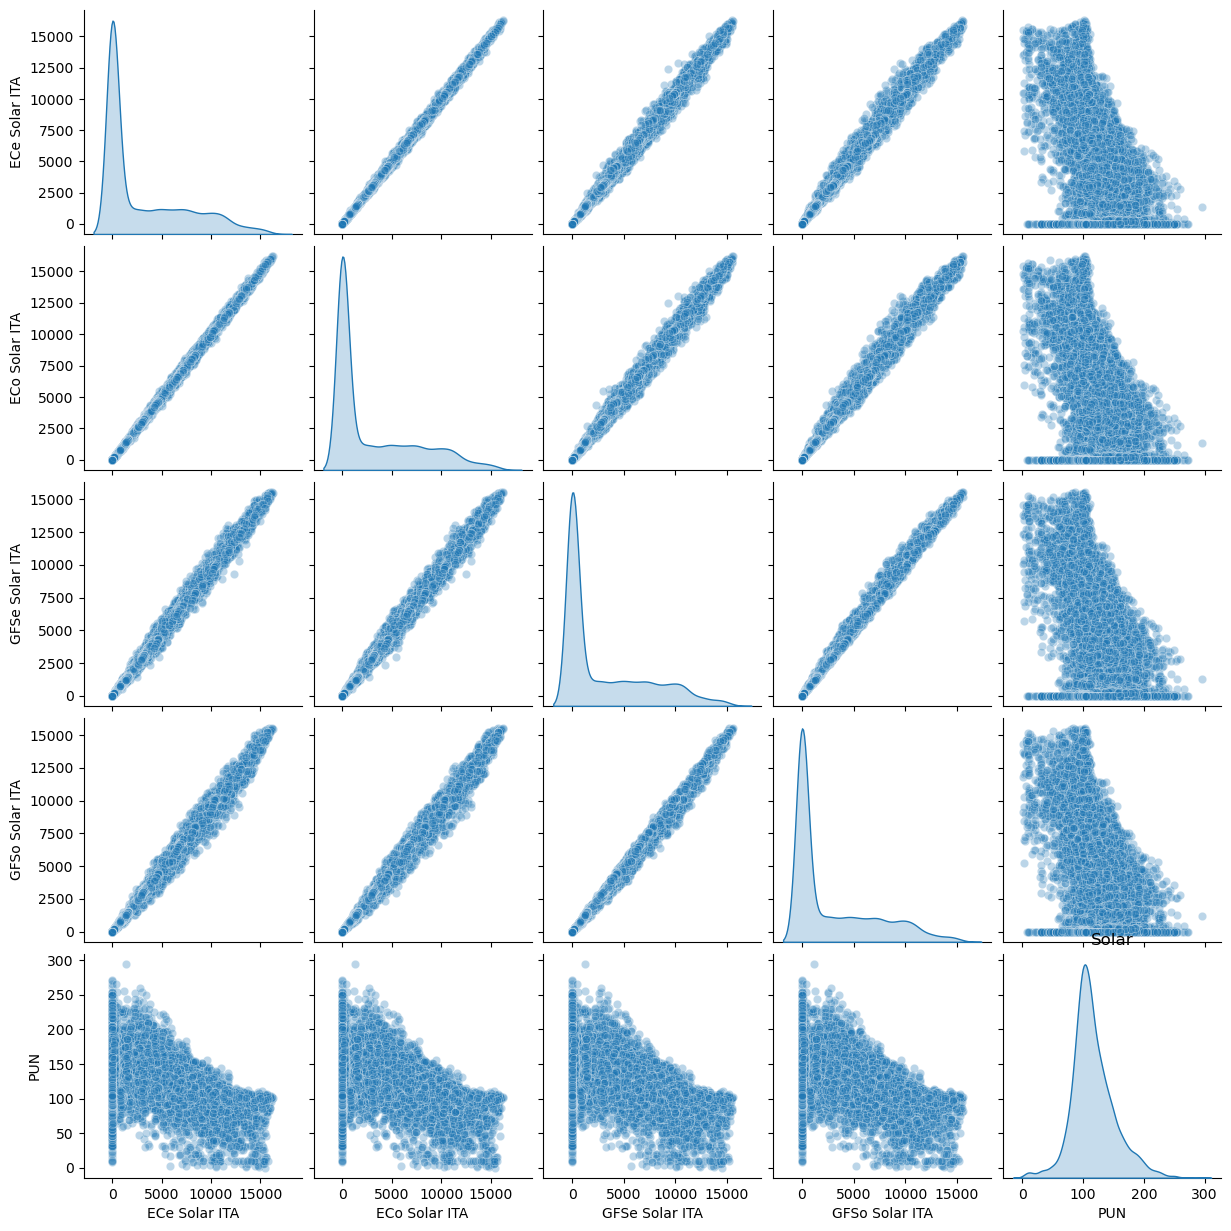

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

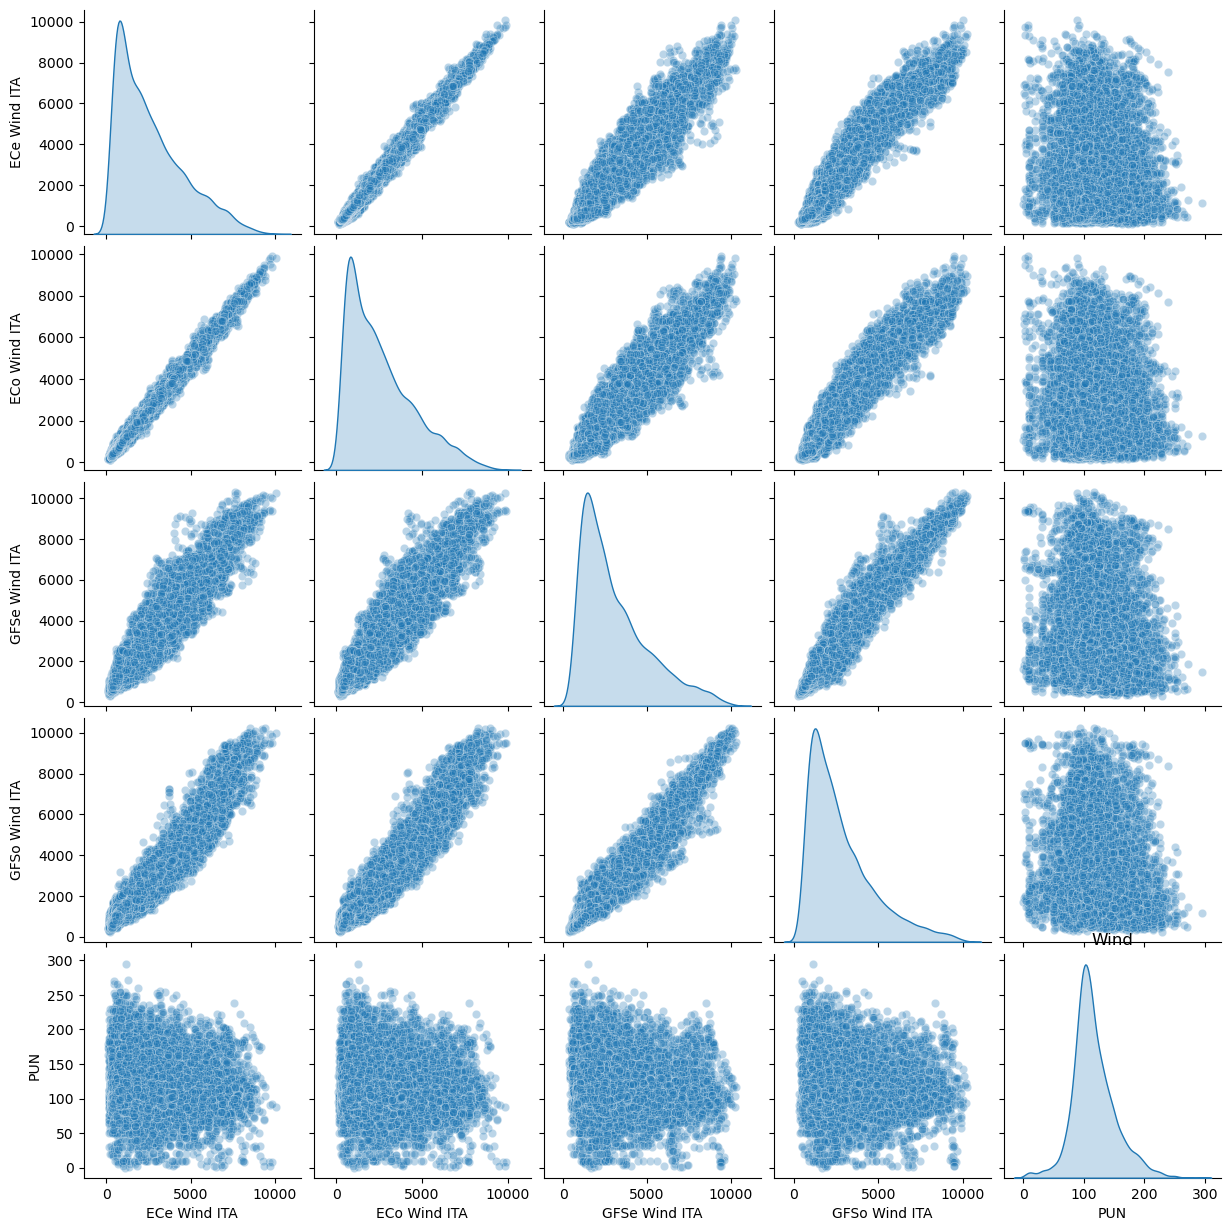

In [ ]:
plt.figure()
sns.pairplot(zone_dataframes['Italy'][['ECe Solar ITA','ECo Solar ITA', 'GFSe Solar ITA', 'GFSo Solar ITA', 'PUN']], diag_kind='kde', plot_kws={'alpha': 0.3})
plt.title('Solar')
plt.show()



sns.pairplot(zone_dataframes['Italy'][['ECe Wind ITA', 'ECo Wind ITA', 'GFSe Wind ITA', 'GFSo Wind ITA' , 'PUN']], diag_kind='kde', plot_kws={'alpha': 0.3 })
plt.title('Wind')
plt.show()
